# Figure S21. Effect of age on $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$ and its robustness across different configurations in the PNC dataset

In [12]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [13]:
import sys
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
import pymare
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, stats

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

## Load data, calculate age effects and ICCs

Load data of the main run:

In [14]:
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()
parcels = transform.load_ordered_parcel_labels('schaefer-100')

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")
# select first rather than best runs for comparability with the other
# robustness analyses which also were done on one run
first_runs = subjects_optima.loc[subjects_optima['SeedMW']==1].index
data = subjects_optima.loc[first_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)

# limit to subsample of 200 subjects
subsample = np.loadtxt(os.path.join(INPUT_DIR, 'pnc_subsample_200.txt'), dtype=str)
data = data.loc[subsample]

# load S_ratio
S_ratio = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
for i, parc in enumerate(parcels):
    for sub, row in data.iterrows():
        S_ratio.loc[sub, parc] = (
            regional_vars[sub][row['SeedMW']].loc[i, 'S_E'] / 
            regional_vars[sub][row['SeedMW']].loc[i, 'S_I']
        )

Split data into two age groups for comparing ICCs between them:

In [15]:
data_by_age = {
    'younger': data.loc[data['age']<data['age'].median()],
    'older': data.loc[data['age']>=data['age'].median()]
}

Load alternative simulations data:

In [16]:
all_data = {}
all_S_ratio = {}
all_data['main'] = data
all_S_ratio['main'] = S_ratio

for alt in ['sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', '6maps_rot', 'homo', 'node']:
    print(alt)
    if alt == 'sch200':
        parcellation_name = 'schaefer-200'
        nodes = 200
    else:
        parcellation_name = 'schaefer-100'
        nodes = 100
    if alt == 'altseed':
        SeedSim = 40
    else:
        SeedSim = 410
    parcels = transform.load_ordered_parcel_labels(parcellation_name)
    if alt not in ['sch200', 'node']:
        # performed using bnm_cuda
        # determine path of pre-curated data
        optima_filename = f'pnc200_{alt}_optima.csv'
        vars_filename = f'pnc200_{alt}_vars.pkz'
        # load pre-curated optima and regional variables data
        if os.path.exists(optima_filename) & os.path.exists(vars_filename):
            curr_subjects_optima = pd.read_csv(optima_filename, index_col=0)
            with open(vars_filename, 'rb') as f:
                curr_regional_vars = pickle.load(f)
        else:
            raise FileNotFoundError("Run Figure 5 first")
        # select the first run and create S_ratio dataframe
        if alt == 'main':
            # select the first run (rather than best run) 
            # data to be comparable to other alternatives
            first_runs = curr_subjects_optima.loc[curr_subjects_optima['SeedMW']==1].index
            curr_data = curr_subjects_optima.loc[first_runs].set_index("sub")
        else:
            curr_data = curr_subjects_optima.set_index('sub')
        curr_S_ratio = pd.DataFrame(index=curr_data.index, columns=parcels, dtype=float)
        for i, parc in enumerate(parcels):
            for sub, row in curr_data.iterrows():
                curr_S_ratio.loc[sub, parc] = (
                    curr_regional_vars[sub][row['SeedMW']].loc[i, 'S_E'] / 
                    curr_regional_vars[sub][row['SeedMW']].loc[i, 'S_I']
                )
    else:
        # performed using cuBNM
        optima_filename = f'pnc200_{alt}_optima.csv'
        S_ratio_filename = f'pnc200_{alt}_S_ratio.csv'
        if os.path.exists(optima_filename) & os.path.exists(S_ratio_filename):
            curr_data = pd.read_csv(optima_filename, index_col=0)
            curr_S_ratio = pd.read_csv(S_ratio_filename, index_col=0)
        else:
            if alt == 'node':
                maps_name = 'node'
            else:
                maps_name = '6maps'
            curr_subjects_optima = {}
            curr_S_ratio = {}
            for sub in tqdm(data.index):
                try:
                    curr_subjects_optima[sub] = pd.read_csv(
                        os.path.join(
                            OUTPUT_DIR['pnc'], 'sim',
                            sub, f'ctx_parc-{parcellation_name}_mean001', 
                            maps_name, 'cmaes_run-0', 'opt.csv'
                        ), index_col=0, header=None).iloc[:, 0]
                except FileNotFoundError:
                    print(sub, "does not exist")
                    continue
                # load simulation data (S_ratio)
                npz_path = glob(
                    os.path.join(
                        OUTPUT_DIR['pnc'], 'sim',
                        sub, f'ctx_parc-{parcellation_name}_mean001', 
                        maps_name, 'cmaes_run-0', 'opt_sim', 'it*.npz')
                )[0]
                sim_data = np.load(npz_path, allow_pickle=True)
                curr_S_ratio[sub] = (
                    sim_data['sim_states'].reshape(-1)[0]['S_E'].squeeze() /
                    sim_data['sim_states'].reshape(-1)[0]['S_I'].squeeze()
                )
            # collect and save optima
            curr_subjects_optima = pd.DataFrame(curr_subjects_optima).T.drop(columns=[np.NaN])
            # remove + and - from GOF measures
            curr_subjects_optima.columns = [s.replace('-','').replace('+','') for s in curr_subjects_optima.columns]
            curr_subjects_optima['fcd_ks'] = -curr_subjects_optima['fcd_ks']
            curr_subjects_optima['fc_diff'] = -curr_subjects_optima['fc_diff']
            curr_S_ratio = pd.DataFrame(curr_S_ratio).T
            curr_S_ratio.columns = parcels
            curr_subjects_optima.to_csv(optima_filename)
            curr_S_ratio.to_csv(S_ratio_filename)
            curr_data = curr_subjects_optima
    # add demographics
    curr_data[['age', 'sex']] = elig_subs.loc[curr_data.index,['age', 'sex']]
    curr_data['Age (y)'] = curr_data['age'] / 12
    # add motion data
    motion = pd.read_csv(
        os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
        delimiter="\t", index_col=0
    ).loc[curr_data.index]
    curr_data = pd.concat([curr_data, motion], axis=1)
    all_data[alt] = curr_data
    all_S_ratio[alt] = curr_S_ratio

sc_temp
sch200
2maps
nmda_gabaa
4maps
inter
altseed
6maps_rot
homo
node


Calculate the age effects of $S^E/S^I$ as well as its ICC (compared to main run) in each configuration across the 200 subsample subjects:

In [17]:
all_stats = {}
all_ICCs = {}
all_ICCs_by_age = {}
alts = ['main', 'sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed', '6maps_rot', 'homo', 'node']
main_alts = ['main', 'sc_temp', 'sch200', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed']

for alt in alts:
    print(alt)
    # set parcellation
    if alt == 'sch200':
        parcellation_name = 'schaefer-200'
        nodes = 200
    else:
        parcellation_name = 'schaefer-100'
        nodes = 100
    parcels = transform.load_ordered_parcel_labels(parcellation_name)
    # combine S_ratio and data
    df = pd.concat([all_S_ratio[alt], all_data[alt]], axis=1)
    df.columns = [f'Sratio_{i}' for i in range(nodes)] + list(df.columns[nodes:])
    # calculate parcel-wise age effects
    t = pd.Series(index=parcels)
    r = pd.Series(index=parcels)
    p = pd.Series(index=parcels)
    Ns = pd.Series(index=parcels)
    outliers = {}
    for i, parc in enumerate(parcels):
        # exclude outliers
        curr_subs = df.index[(scipy.stats.zscore(df.loc[:, f'Sratio_{i}']).abs() < 3)]
        outliers[parc] = set(df.index) - set(curr_subs)
        model_df = df.loc[curr_subs]
        # fit the confound removal model to calculate pearson's r of the
        # residual of S_ratio with age as an easy-to-interpret effect size
        res_conf = smf.ols(f"Sratio_{i} ~ gof + sex + mean_rms", data=model_df).fit()
        r.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
        # fit the model
        mod = smf.ols(f'Sratio_{i} ~ age + gof + sex + mean_rms', data=model_df)
        res = mod.fit()
        t.loc[parc] = res.tvalues['age']
        p.loc[parc] = res.pvalues['age']
        Ns.loc[parc] = len(curr_subs)
    
    # FDR correction
    _, p_fdr = statsmodels.stats.multitest.fdrcorrection(p)
    p_fdr = pd.Series(p_fdr, index=parcels)
    
    # aggregate stats
    all_stats[alt] = pd.DataFrame({"t": t, "r": r, "p": p, "p_fdr": p_fdr, "N": Ns})
    all_stats[alt].to_csv(f"p_pnc200_{alt}_Sratio_age_stats.csv")

    # calculate ICC
    if alt in main_alts[1:]:
        # for schaefer-200 to make the parcels comparable
        # reparcellate main from schaefer-100 to schaefer-200
        if alt == 'sch200':
            S_ratio_main = transform.parcellate_surf(transform.deparcellate_surf(all_S_ratio['main'].T, 'schaefer-100'), 'schaefer-200', concat=True).T
            S_ratio_main.index=all_S_ratio['main'].index
        else:
            S_ratio_main = all_S_ratio['main']
        # ICC across all subjects
        all_ICCs[alt] = pd.Series(index=parcels, dtype=float)
        for i, parc in enumerate(parcels):
            icc_df = pd.DataFrame(index=all_data[alt].index, columns=['main', 'alt'], dtype=float)
            for sub in S_ratio.index:
                icc_df.loc[sub, 'main'] = S_ratio_main.loc[sub, parc]
                icc_df.loc[sub, 'alt'] = all_S_ratio[alt].loc[sub, parc]
            all_ICCs[alt].loc[parc] = stats.madicc(icc_df.loc[:, 'main'], icc_df.loc[:, 'alt'])
        # ICC in younger vs older age groups
        all_ICCs_by_age[alt] = pd.DataFrame(index=parcels, dtype=float)
        for age in data_by_age.keys():
            for i, parc in enumerate(parcels):
                icc_df = pd.DataFrame(index=data_by_age[age].index, columns=['main', 'alt'], dtype=float)
                for sub in data_by_age[age].index:
                    icc_df.loc[sub, 'main'] = S_ratio_main.loc[sub, parc]
                    icc_df.loc[sub, 'alt'] = all_S_ratio[alt].loc[sub, parc]
                all_ICCs_by_age[alt].loc[parc, age] = stats.madicc(icc_df.loc[:, 'main'], icc_df.loc[:, 'alt'])
        all_ICCs_by_age[alt]['all'] = all_ICCs[alt]

main
sc_temp
sch200
2maps
nmda_gabaa
4maps
inter
altseed
6maps_rot
homo
node


## A. Main run with default configurations

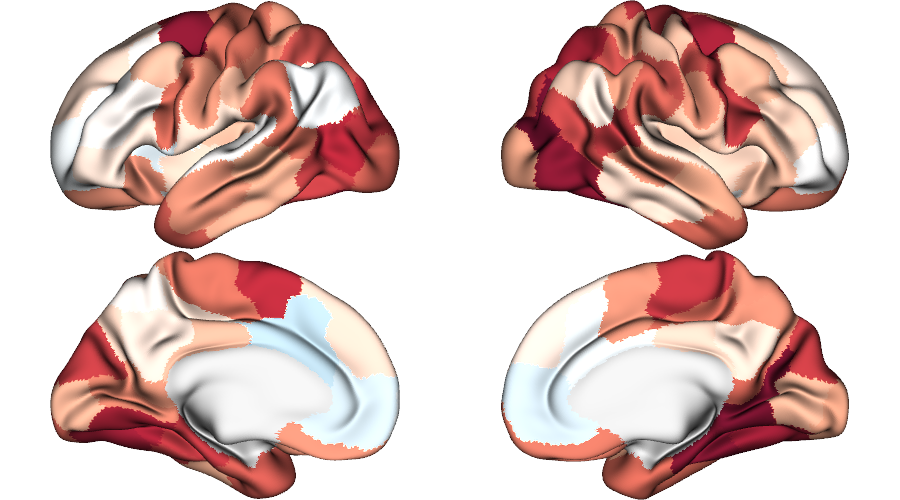

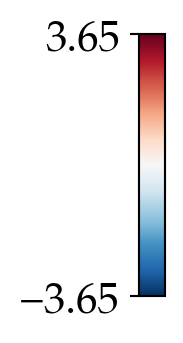

In [18]:
vmin = min(all_stats['main']['t'].values.min(), -all_stats['main']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['main']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

## B. Template SC

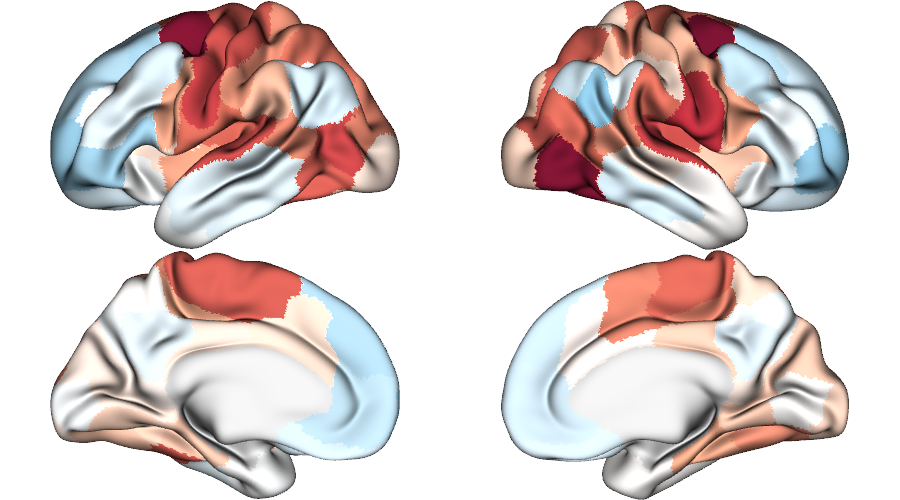

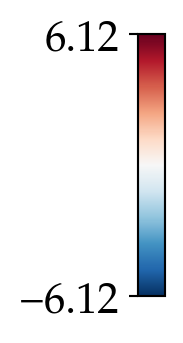

In [19]:
vmin = min(all_stats['sc_temp']['t'].values.min(), -all_stats['sc_temp']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['sc_temp']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main:

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.5597274771035382 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.6861811354518218 ; p-vlaue: 0.0


<Axes: xlabel='sc_temp', ylabel='main'>

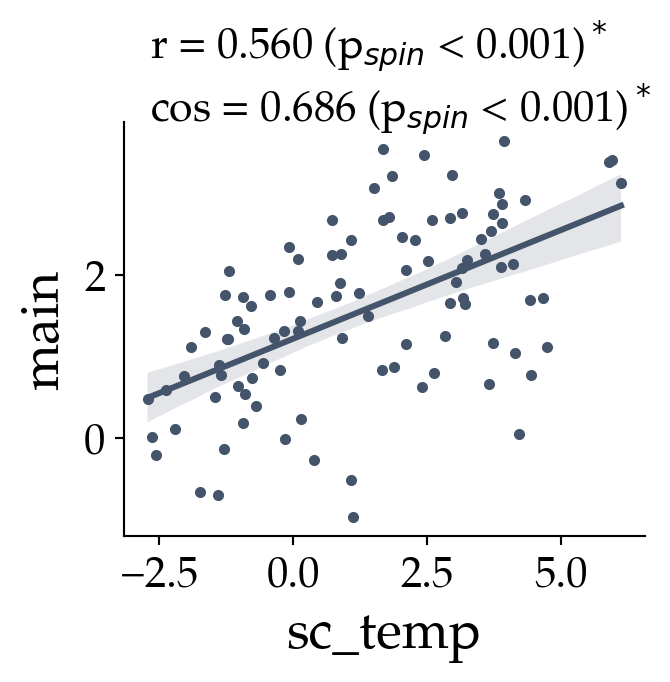

In [20]:
plot.reg_plot(
    all_stats['sc_temp'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='sc_temp', ylabel='main'
)

## C. Schaefer-200

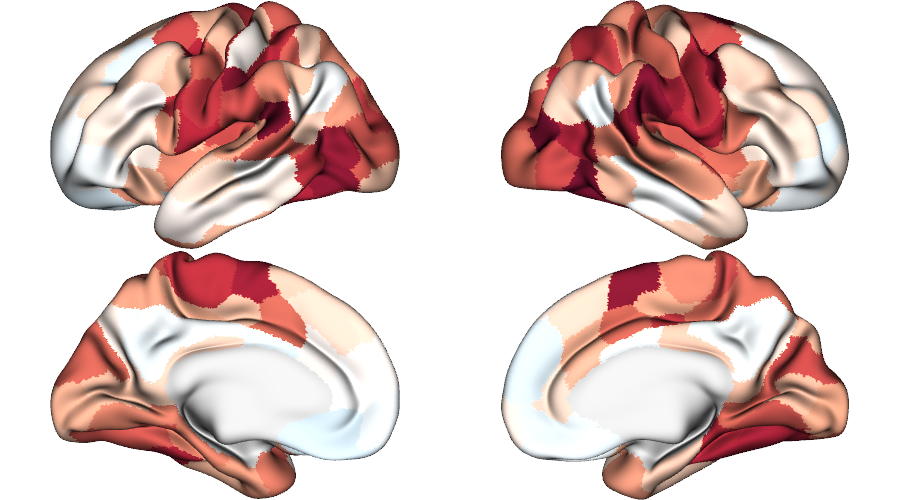

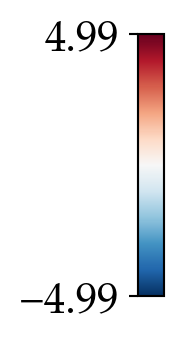

In [21]:
vmin = min(all_stats['sch200']['t'].values.min(), -all_stats['sch200']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['sch200']['t'], 'schaefer-200', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main:

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.6336792058474183 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.8796742664078022 ; p-vlaue: 0.0


<Axes: xlabel='sch200', ylabel='main'>

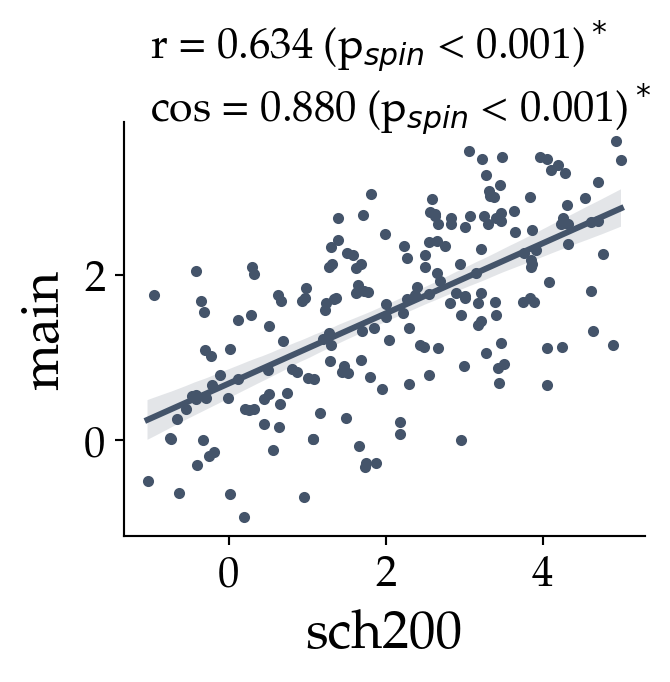

In [22]:
# project main age effect map from sch100->vertices->sch200
t_age_main_reparc_sch200 = transform.parcellate_surf(
    transform.deparcellate_surf(
        all_stats['main']['t'], 'schaefer-100'
    ), 'schaefer-200', concat=True).iloc[:, 0]
plot.reg_plot(
    all_stats['sch200'][['t']], t_age_main_reparc_sch200.to_frame(), 'schaefer-200',
    xlabel='sch200', ylabel='main'
)

## D. Alternative heterogeneity maps

### (left) T1w/T2w & FC G1

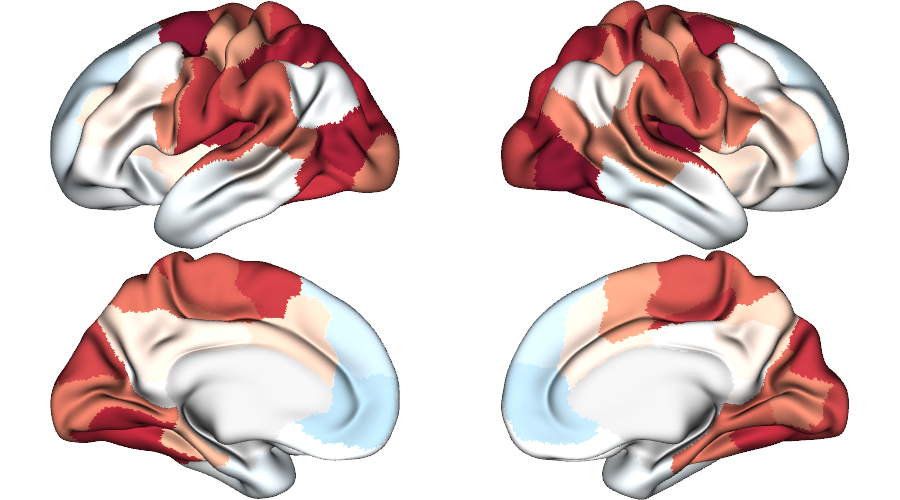

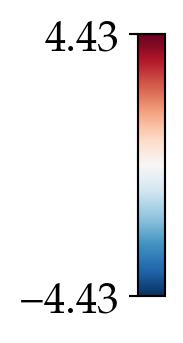

In [23]:
vmin = min(all_stats['2maps']['t'].values.min(), -all_stats['2maps']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['2maps']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main:

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.6047049753672291 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.8372084493044658 ; p-vlaue: 0.0


<Axes: xlabel='2maps', ylabel='main'>

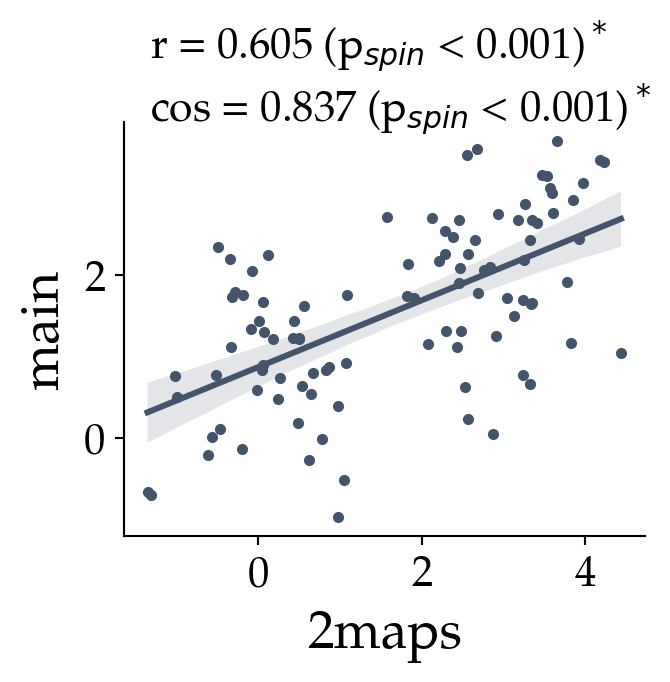

In [24]:
plot.reg_plot(
    all_stats['2maps'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='2maps', ylabel='main'
)

### (middle) NMDA & GABA$_{A/BZ}$

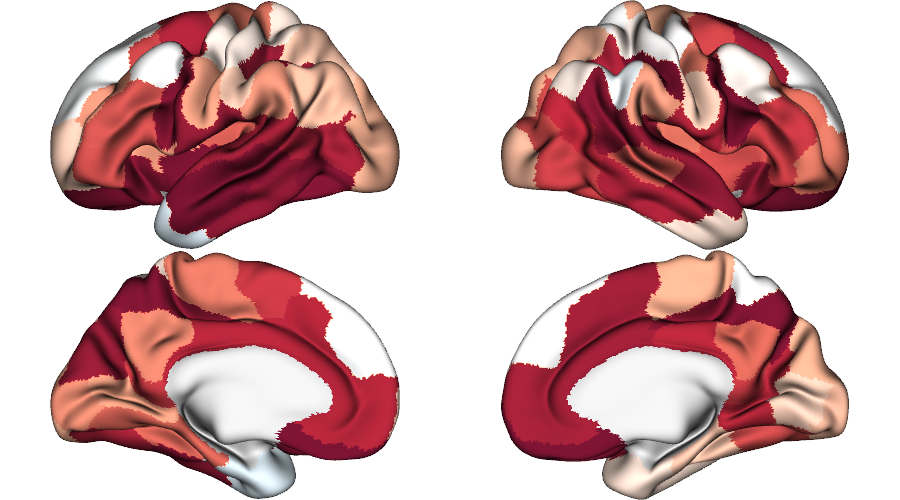

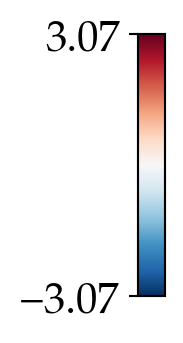

In [25]:
vmin = min(all_stats['nmda_gabaa']['t'].values.min(), -all_stats['nmda_gabaa']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['nmda_gabaa']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main:

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: -0.010382959255104416 ; p-vlaue: 0.924
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.7367500592515344 ; p-vlaue: 0.512


<Axes: xlabel='nmda_gabaa', ylabel='main'>

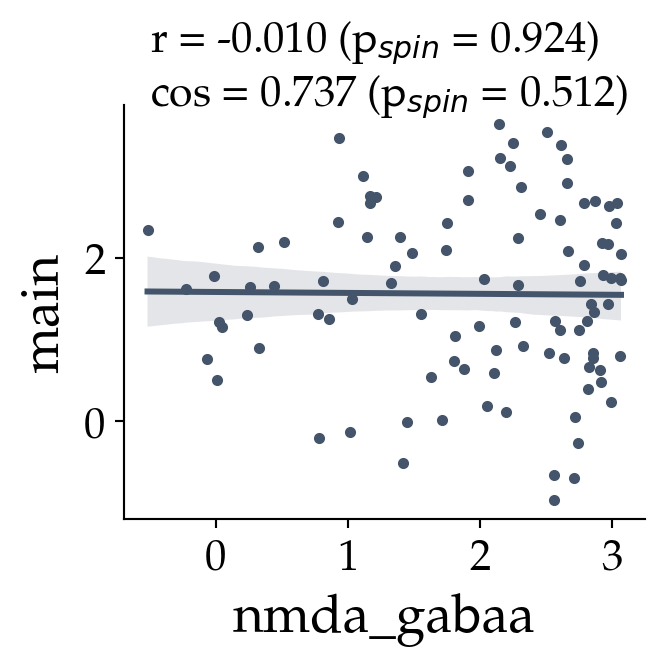

In [26]:
plot.reg_plot(
    all_stats['nmda_gabaa'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='nmda_gabaa', ylabel='main'
)

### (right) T1w/T2w, FC G1, NMDA & GABA$_{A/BZ}$

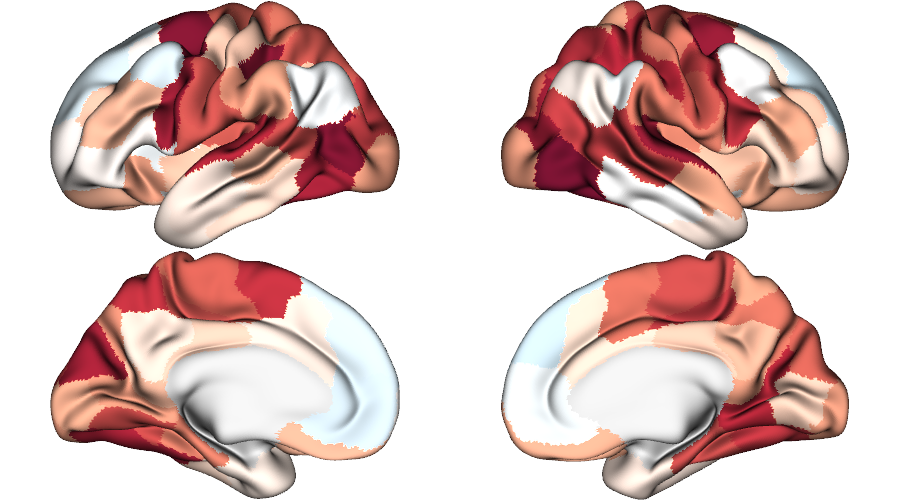

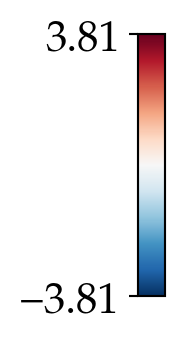

In [27]:
vmin = min(all_stats['4maps']['t'].values.min(), -all_stats['4maps']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['4maps']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.679890092102275 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.8993543028584832 ; p-vlaue: 0.0


<Axes: xlabel='4maps', ylabel='main'>

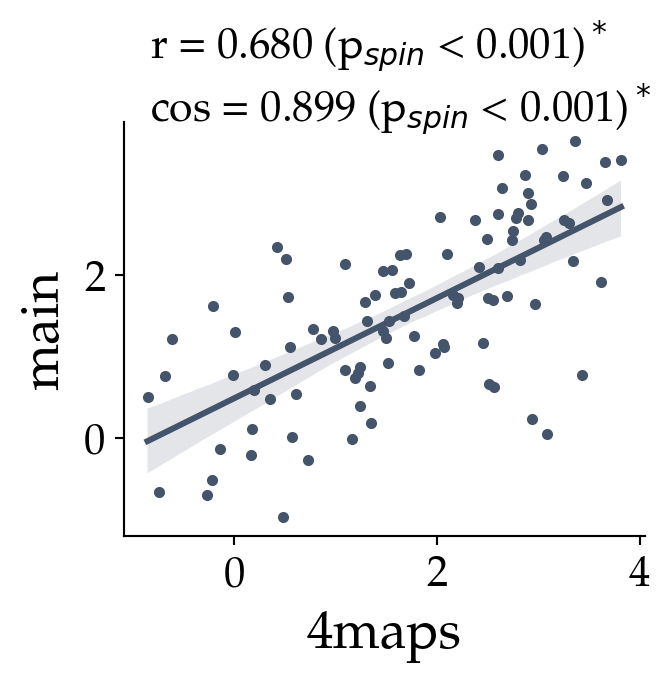

In [28]:
plot.reg_plot(
    all_stats['4maps'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='4maps', ylabel='main'
)

## E. Including inter-hemispheric connections in cost

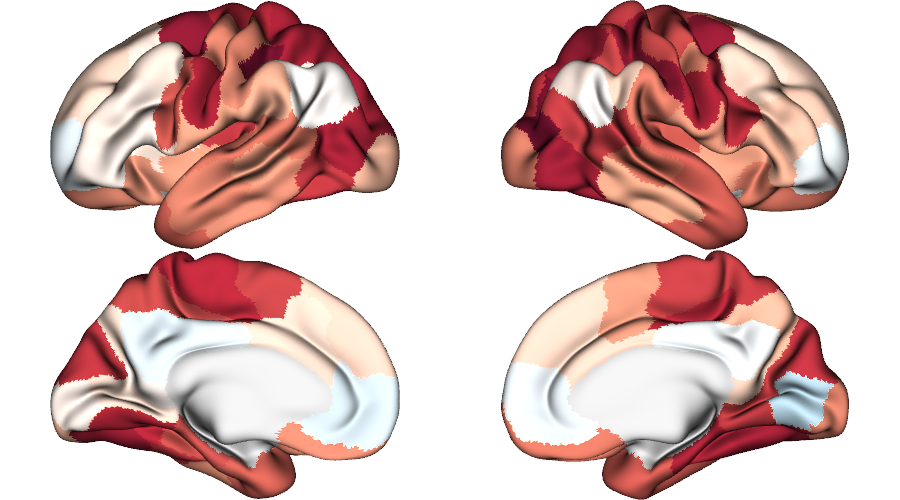

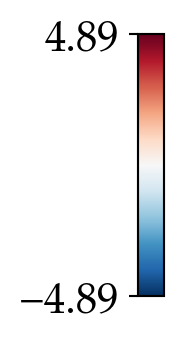

In [29]:
vmin = min(all_stats['inter']['t'].values.min(), -all_stats['inter']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['inter']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main:

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.732715599298736 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.9161250915683807 ; p-vlaue: 0.0


<Axes: xlabel='inter', ylabel='main'>

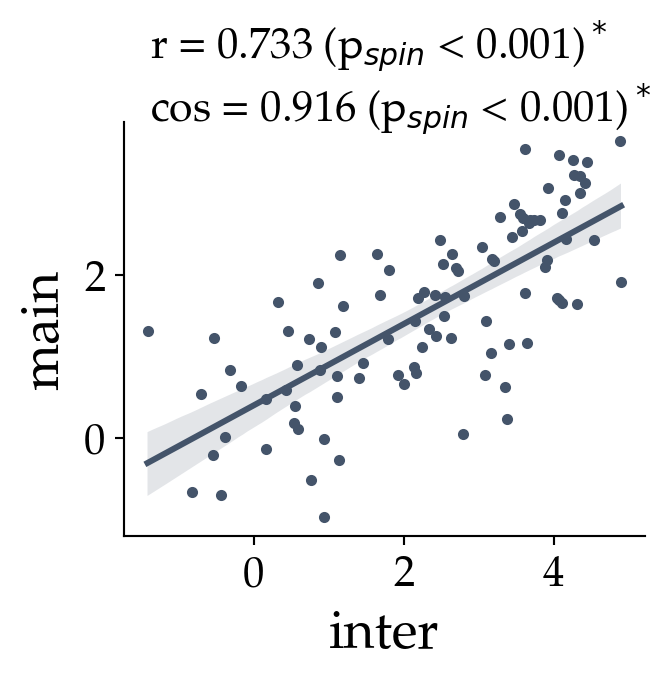

In [30]:
plot.reg_plot(
    all_stats['inter'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='inter', ylabel='main'
)

## F. Alternative noise seed

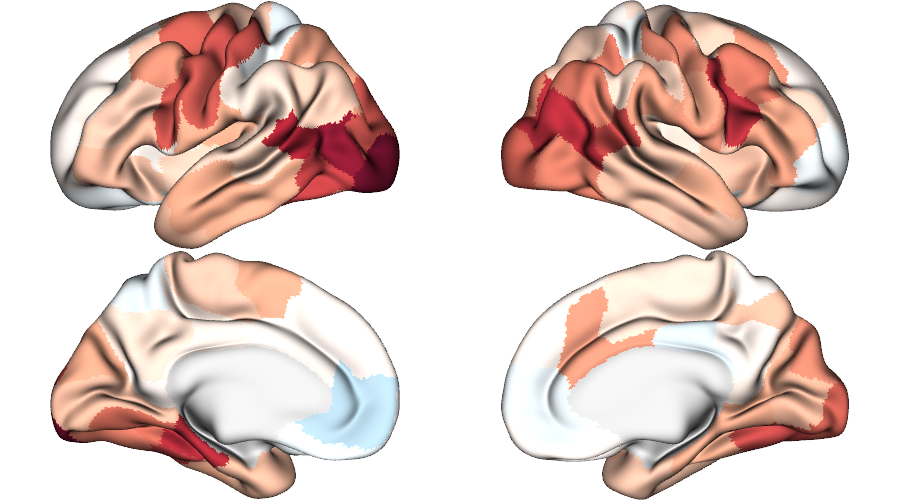

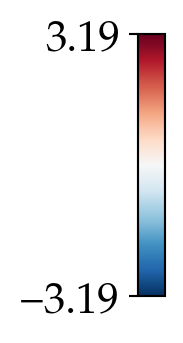

In [31]:
vmin = min(all_stats['altseed']['t'].values.min(), -all_stats['altseed']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(all_stats['altseed']['t'], 'schaefer-100', concat=True, space='fsaverage'), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

Comparison with main:

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.5382073892409773 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.8419045675181457 ; p-vlaue: 0.0


<Axes: xlabel='altseed', ylabel='main'>

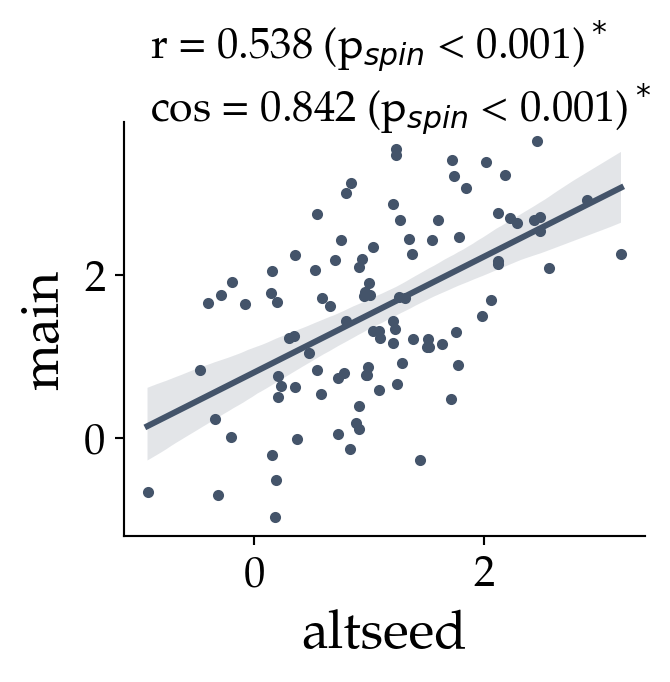

In [32]:
plot.reg_plot(
    all_stats['altseed'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='altseed', ylabel='main'
)

## F. Pooled age effects

In [33]:
# for schaefer-200 reparcellate it into schaefer-100 so the maps can be combined
all_stats['sch200reparc'] = transform.parcellate_surf(transform.deparcellate_surf(all_stats['sch200'], 'schaefer-200'), 'schaefer-100', concat=True)
all_stats['sch200reparc'].columns = all_stats['main'].columns
all_stats['sch200reparc']['N'] = all_stats['sch200reparc']['N'].round().astype('int')

# convert Rs and Ns of analyses reported in Fig 5 to dataframes
# which will be used in the meta-analyses
meta_alts = ['main', 'sc_temp', 'sch200reparc', '2maps', 'nmda_gabaa', '4maps', 'inter', 'altseed']
all_Rs = pd.DataFrame({k: all_stats[k]['r'] for k in meta_alts})
all_Ns = pd.DataFrame({k: all_stats[k]['N'].astype('int') for k in meta_alts})

# in each node run a REML meta-aanlysis using PyMARE
# with the partial correlation of age with <I_Ei> as the effect size
meta_results = {}
for parc in parcels:
    dset = pymare.effectsize.OneSampleEffectSizeConverter(
        r = all_Rs.loc[parc, :], 
        n = all_Ns.loc[parc, :]
    ).to_dataset(measure='R')
    est = pymare.estimators.VarianceBasedLikelihoodEstimator(method="REML").fit_dataset(dset)
    results = est.summary()
    meta_results[parc] = results.to_df().iloc[0, 1:]
    meta_het_stats = results.get_heterogeneity_stats()
    meta_results[parc]['I^2'] = meta_het_stats['I^2'][0]
    meta_results[parc]['p(Q)'] = meta_het_stats['p(Q)'][0]
meta_results = pd.DataFrame(meta_results).T.astype(float)
# FDR correction
_, meta_results['p_fdr'] = statsmodels.stats.multitest.fdrcorrection(meta_results['p-value'])

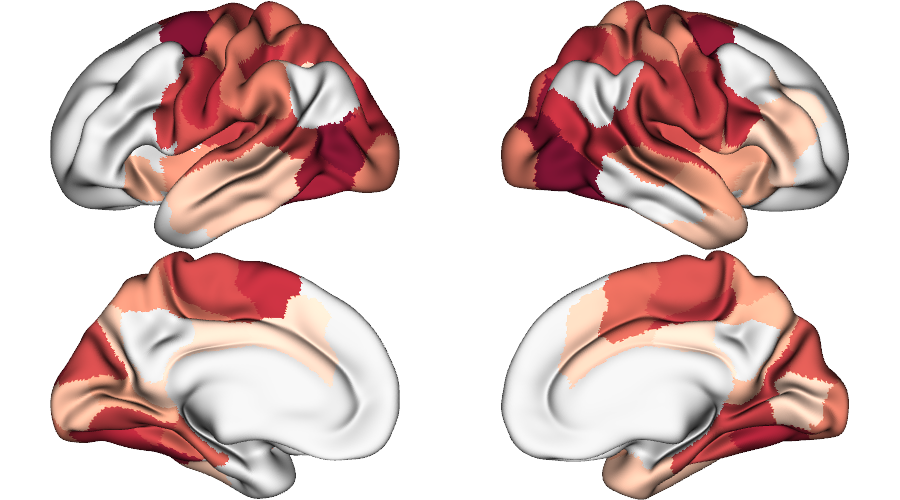

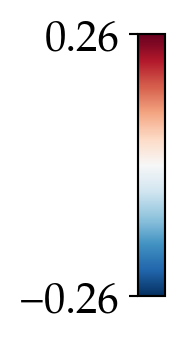

In [34]:
vmin = min(meta_results['estimate'].values.min(), -meta_results['estimate'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        meta_results['estimate'][meta_results['p_fdr']<0.05], 
        'schaefer-100', concat=True, space='fsaverage'
    ), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='grid',
)

## Text. Node-level intraclass correlation of $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$ across Gaussian noise random seeds

Load the simulation data of alternative seeds:

In [35]:
orig_seed = 410
alt_seeds = list(range(50))
all_seed_Sratio = {}
for rand_seed in [orig_seed]+alt_seeds:
    base_dir = os.path.join('./sim_seed', f'SeedSim-{rand_seed}')
    sim_states = np.load(os.path.join(base_dir, 'states.npz'))
    all_seed_Sratio[rand_seed] = pd.DataFrame(sim_states['S_E']/sim_states['S_I'], index=data.index, columns=parcels)

Calculate ICC:

In [36]:
icc_seed = pd.DataFrame(index=parcels, columns=range(50), dtype=float)
for rand_seed in tqdm(range(50)):
    for i, parc in enumerate(parcels):
        icc_df = pd.DataFrame(
            {'orig': all_seed_Sratio[orig_seed].iloc[:, i], rand_seed: all_seed_Sratio[rand_seed].iloc[:, i]},
            index=data.index, dtype=float
        )
        icc_seed.loc[parc, rand_seed] = stats.madicc(icc_df.loc[:, 'orig'], icc_df.loc[:, rand_seed])

100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.84it/s]


In [37]:
icc_seed.describe()

0           1           2           3           4           5   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.999124    0.999153    0.999274    0.999135    0.999044    0.998726   
std      0.001292    0.001118    0.001013    0.001301    0.001240    0.002276   
min      0.993383    0.994230    0.994060    0.990277    0.993266    0.984828   
25%      0.998850    0.998776    0.999022    0.998971    0.998834    0.998631   
50%      0.999658    0.999559    0.999693    0.999493    0.999498    0.999620   
75%      0.999903    0.999934    0.999899    0.999894    0.999859    0.999857   
max      0.999986    0.999993    0.999995    0.999994    0.999988    0.999989   

               6           7           8           9   ...          40  \
count  100.000000  100.000000  100.000000  100.000000  ...  100.000000   
mean     0.999166    0.998991    0.998586    0.999155  ...    0.998968   
std      0.001189    0.001355    0.002523    0.001294  ...    0.001248   
min      0.993774    0.992490    0.987151    0.990269  ...    0.994553   
25%      0.998914    0.998688    0.998652    0.998684  ...    0.998594   
50%      0.999682    0.999569    0.999583    0.999676  ...    0.999461   
75%      0.999891    0.999871    0.999897    0.999898  ...    0.999843   
max      0.999992    0.999986    0.999987    0.999987  ...    0.999996   

               41          42          43          44          45          46  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.999244    0.998958    0.998836    0.999159    0.999109    0.999046   
std      0.001297    0.001700    0.001937    0.001146    0.001198    0.001345   
min      0.992240    0.990984    0.988947    0.992763    0.993709    0.993109   
25%      0.999271    0.998712    0.998931    0.998563    0.998926    0.998831   
50%      0.999719    0.999705    0.999631    0.999715    0.999625    0.999611   
75%      0.999917    0.999909    0.999880    0.999911    0.999858    0.999894   
max      0.999985    0.999992    0.999990    0.999989    0.999982    0.999989   

               47          48          49  
count  100.000000  100.000000  100.000000  
mean     0.999008    0.998973    0.999046  
std      0.001452    0.001708    0.001290  
min      0.990983    0.990274    0.993291  
25%      0.998802    0.998858    0.998476  
50%      0.999528    0.999672    0.999640  
75%      0.999831    0.999876    0.999917  
max      0.999990    0.999992    0.999992  

[8 rows x 50 columns]

Take median across 50 random seeds

In [38]:
icc_seed_median = icc_seed.median(axis=1)
icc_seed_median.describe()

count    100.000000
mean       0.999501
std        0.000553
min        0.995757
25%        0.999371
50%        0.999687
75%        0.999798
max        0.999959
dtype: float64

## Text. Node-level intraclass correlation of $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$ across optimization runs

In [39]:
icc_opt = pd.Series(index=parcels, dtype=float)
for i, parc in enumerate(parcels):
    icc_df = pd.DataFrame(index=data.index, columns=[1, 2], dtype=float)
    for sub in data.index:
        for SeedMW in [1, 2]:
            icc_df.loc[sub, SeedMW] = regional_vars[sub][SeedMW].loc[i, 'S_E'] / regional_vars[sub][SeedMW].loc[i, 'S_I']
    icc_opt.loc[parc] = stats.madicc(icc_df.iloc[:, 0], icc_df.iloc[:, 1])

In [40]:
icc_opt.describe()

count    100.000000
mean       0.963383
std        0.013344
min        0.918459
25%        0.955158
50%        0.966285
75%        0.973018
max        0.988087
dtype: float64